# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [80]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd

In [85]:
# Read vehicles from CSV
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [82]:
# Exploring distribution of numeric features

# Plot KDE dist plots of vehicle price, odometer, year
plt.figure(figsize=[17,5])
plt.subplot(1, 3, 1)
sns.distplot(vehicles['price'], kde=True)
plt.title('Distribution of Price')

# Other distribution plots
plt.subplot(1, 3, 2)
sns.distplot(vehicles['odometer'], kde=True)
plt.title('Distribution of Odometer')

plt.subplot(1, 3, 3)
sns.distplot(vehicles['year'])
plt.title('Distribution of Year')

#Conclusion: Prices are skewed toward 0

Text(0.5, 1.0, 'Distribution of Year')

Before cleaning prices below 2k and above threshold of 80K, # of vehicles:
426880
After cleaning prices below 2k and above threshold of 80K, # of vehicles:
372276


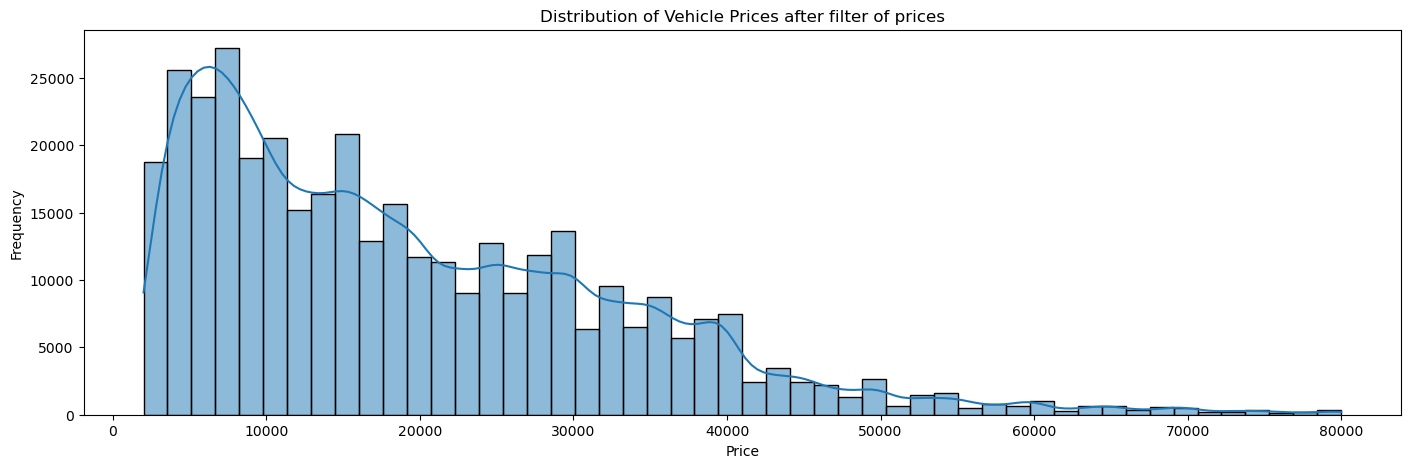

Text(0.5, 1.0, 'Distribution of Year')

In [86]:
# To address skewed distribution, retain prices between 2K - 80K (effectively removing prices outside the lower and upper bounds)
price_threshold = 80000

print("Before cleaning prices below 2k and above threshold of 80K, # of vehicles:")
print(len(vehicles))

# Filter out prices below 2k and above the price threshold
vehicles = vehicles[(vehicles['price'] <= price_threshold) & (vehicles['price'] >= 2000)]
print("After cleaning prices below 2k and above threshold of 80K, # of vehicles:")
print(len(vehicles))      

# Plot the histogram of vehicle prices
plt.figure(figsize=(17, 5))
sns.histplot(vehicles['price'], bins=50, kde=True)  
plt.title('Distribution of Vehicle Prices after filter of prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
      
# Exploring same distribution after prices filter
plt.figure(figsize=[17,5])
plt.subplot(1, 3, 1)
sns.distplot(vehicles['price'], kde=True)
plt.title('Distribution of Price')

# Other distribution plots
plt.subplot(1, 3, 2)
sns.distplot(vehicles['odometer'], kde=True)
plt.title('Distribution of Odometer')

plt.subplot(1, 3, 3)
sns.distplot(vehicles['year'])
plt.title('Distribution of Year')

Missing values before cleaning:
id                   0
region               0
price                0
year              1104
manufacturer     14259
model             4042
condition       140070
cylinders       152131
fuel              2572
odometer          2049
title_status      6471
transmission      1789
VIN             140208
drive           112064
size            268217
type             78275
paint_color     105649
state                0
dtype: int64
After cleaning rows with NaN's, # of vehicles:
31278
Missing values after cleaning:
id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64


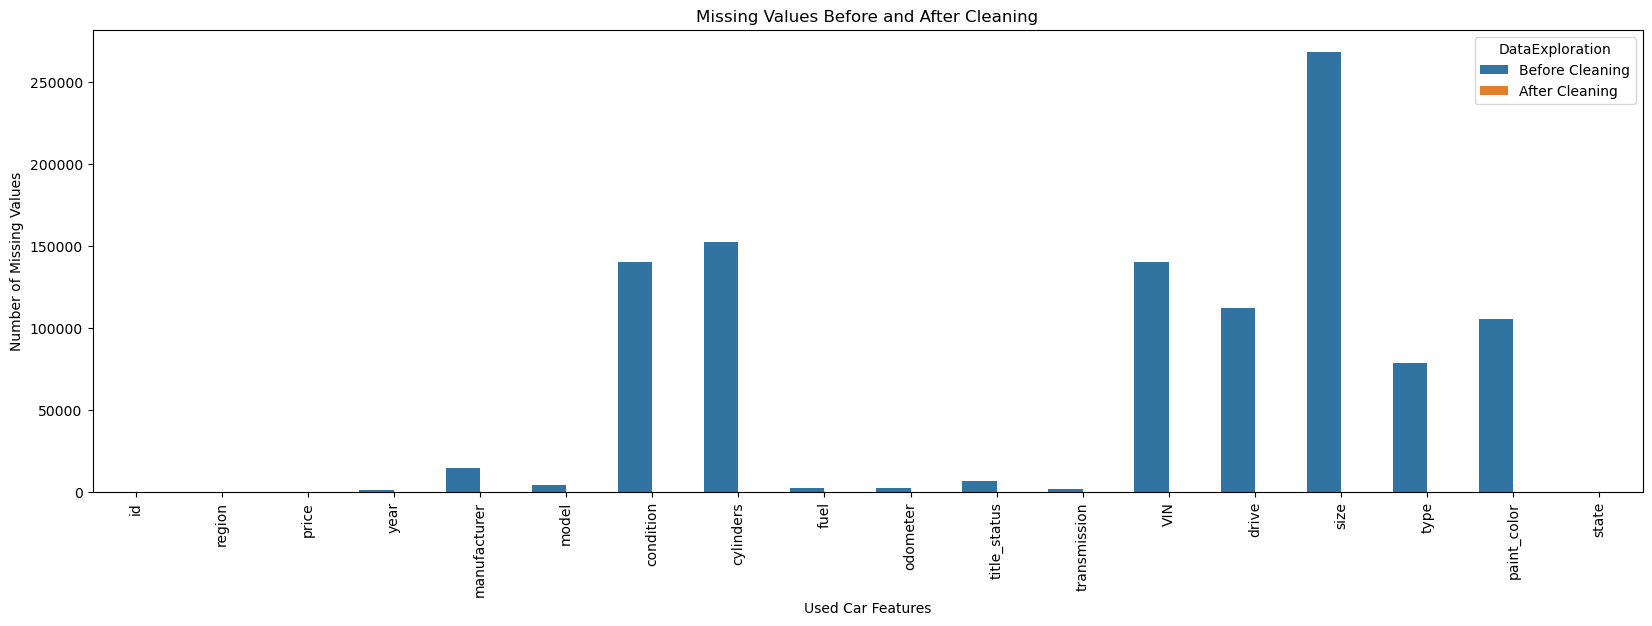


After dropping rows with missing values, length of data-set: 31278


In [87]:
# Exploratory to drop any rows with missing values

# Check missing values
missing_before_clean = vehicles.isnull().sum()
print("Missing values before cleaning:")
print(missing_before_clean)

# Drop rows with NaNs
vehicles = vehicles.dropna()
print("After cleaning rows with NaN's, # of vehicles:")
print(len(vehicles)) 

# ReCheck missing values
missing_after_clean = vehicles.isnull().sum()
print("Missing values after cleaning:")
print(missing_after_clean)

# Combine the missing values into a DataFrame for visualization
missing_values_df = pd.DataFrame({
    'Before Cleaning': missing_before_clean,
    'After Cleaning': missing_after_clean
}).reset_index()

# Melt the DataFrame for easier plotting with Seaborn
missing_values_melted = missing_values_df.melt(id_vars='index', var_name='DataExploration', value_name='Missing Values')

# Plot the missing values
plt.figure(figsize=(20, 6))
sns.barplot(x='index', y='Missing Values', hue='DataExploration', data=missing_values_melted)
plt.title('Missing Values Before and After Cleaning')
plt.xlabel('Used Car Features')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.show()

# Create a figure with subplots to show distribution of
# 1. vehicle prices after filter and clean of missing values, and 
# 2. year with cleaned missing values data-set
plt.figure(figsize=(17, 6))

# Plot the histogram of vehicle prices
plt.subplot(1, 2, 1)
sns.histplot(vehicles['price'], bins=50, kde=True)
plt.title('Distribution of Vehicle Prices (2k-80K) with missing valued rows cleaned')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Plot the histogram of vehicle years
plt.subplot(1, 2, 2)
sns.histplot(vehicles['year'].dropna(), bins=50, kde=True)  
plt.title('Distribution of Vehicle Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Size of data-set now after dropping rows with missing values
print(f"\nAfter dropping rows with missing values, length of data-set: {len(vehicles)}")


Unique size: ['full-size' 'mid-size' 'compact' 'sub-compact']


<Figure size 2500x600 with 0 Axes>

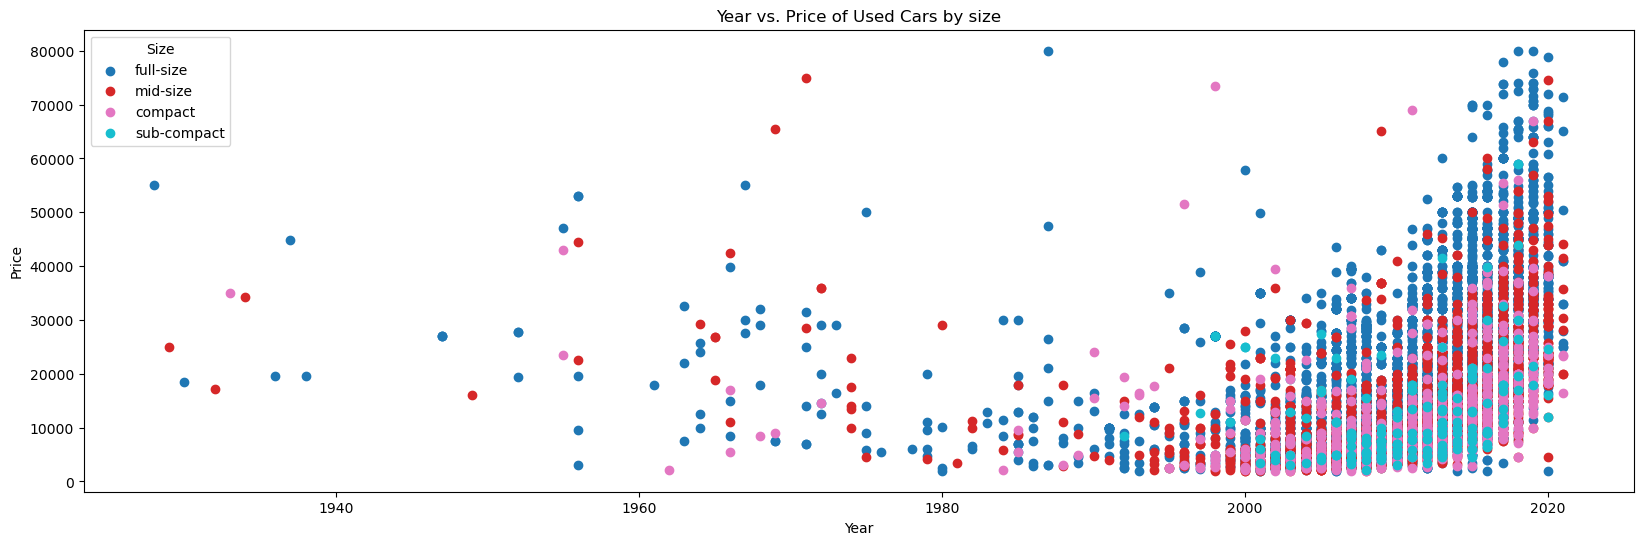

Unique manufacturer: ['ford' 'hyundai' 'mercedes-benz' 'subaru' 'nissan' 'ram' 'chevrolet'
 'toyota' 'gmc' 'volkswagen' 'porsche' 'kia' 'jeep' 'infiniti' 'bmw'
 'lexus' 'dodge' 'honda' 'mercury' 'chrysler' 'mitsubishi' 'audi'
 'cadillac' 'acura' 'buick' 'mini' 'pontiac' 'mazda' 'jaguar' 'lincoln'
 'volvo' 'rover' 'fiat' 'saturn' 'tesla' 'land rover' 'alfa-romeo'
 'harley-davidson' 'aston-martin']


Unique type: ['truck' 'SUV' 'sedan' 'hatchback' 'pickup' 'wagon' 'convertible' 'coupe'
 'van' 'other' 'mini-van' 'offroad' 'bus']


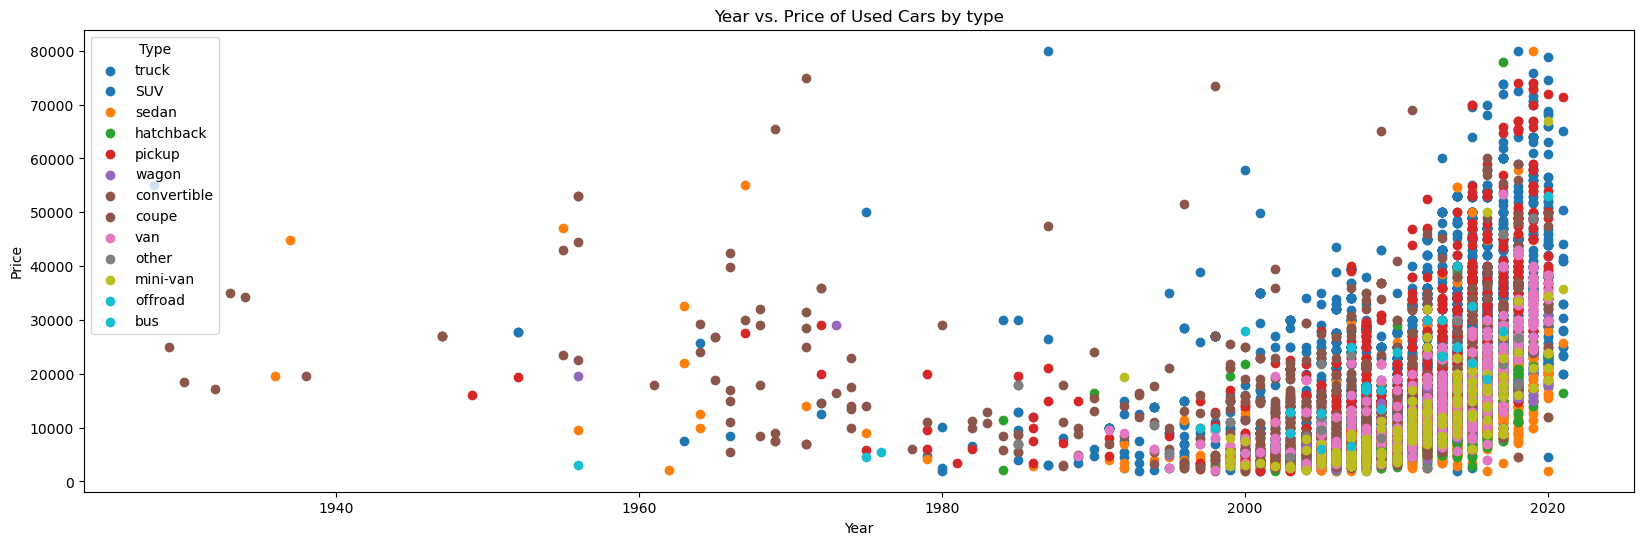

Unique transmission: ['automatic' 'other' 'manual']


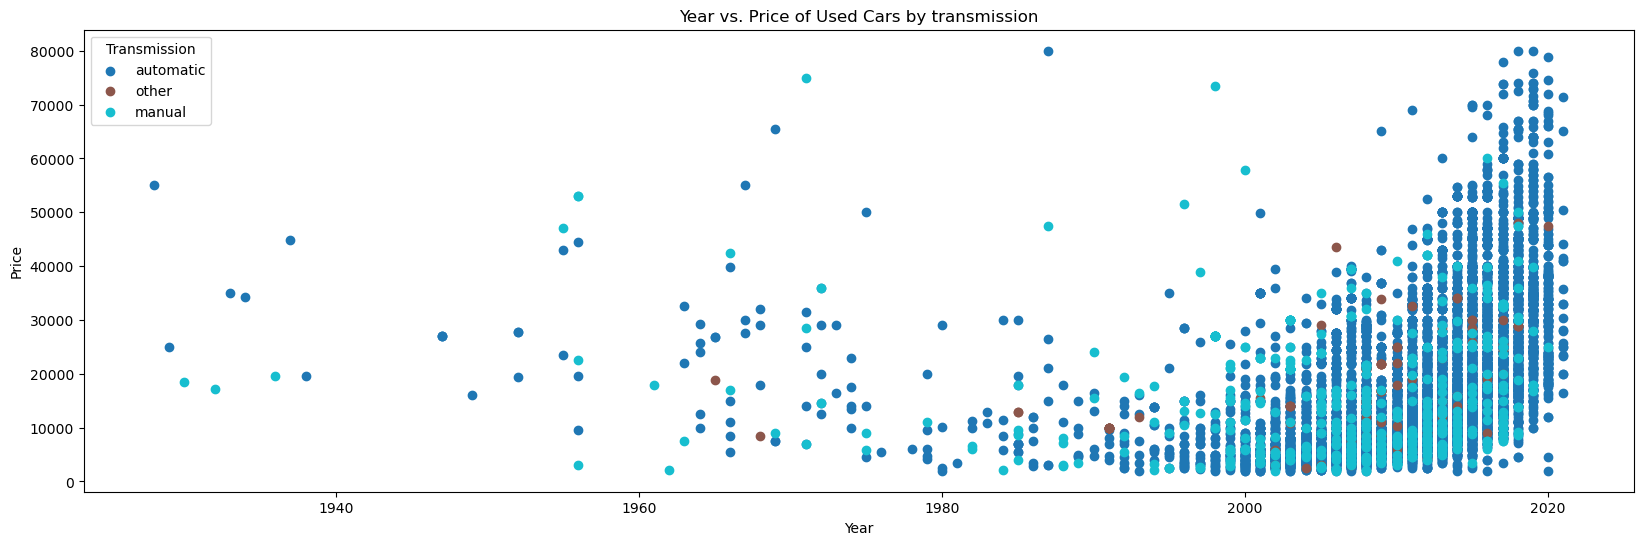

Unique condition: ['good' 'excellent' 'new' 'like new' 'fair' 'salvage']


Unique cylinders: ['8 cylinders' '4 cylinders' '6 cylinders' '10 cylinders' 'other'
 '3 cylinders' '5 cylinders' '12 cylinders']


Unique title_status: ['clean' 'rebuilt' 'lien' 'salvage' 'missing']


Unique fuel: ['diesel' 'gas' 'electric' 'hybrid' 'other']


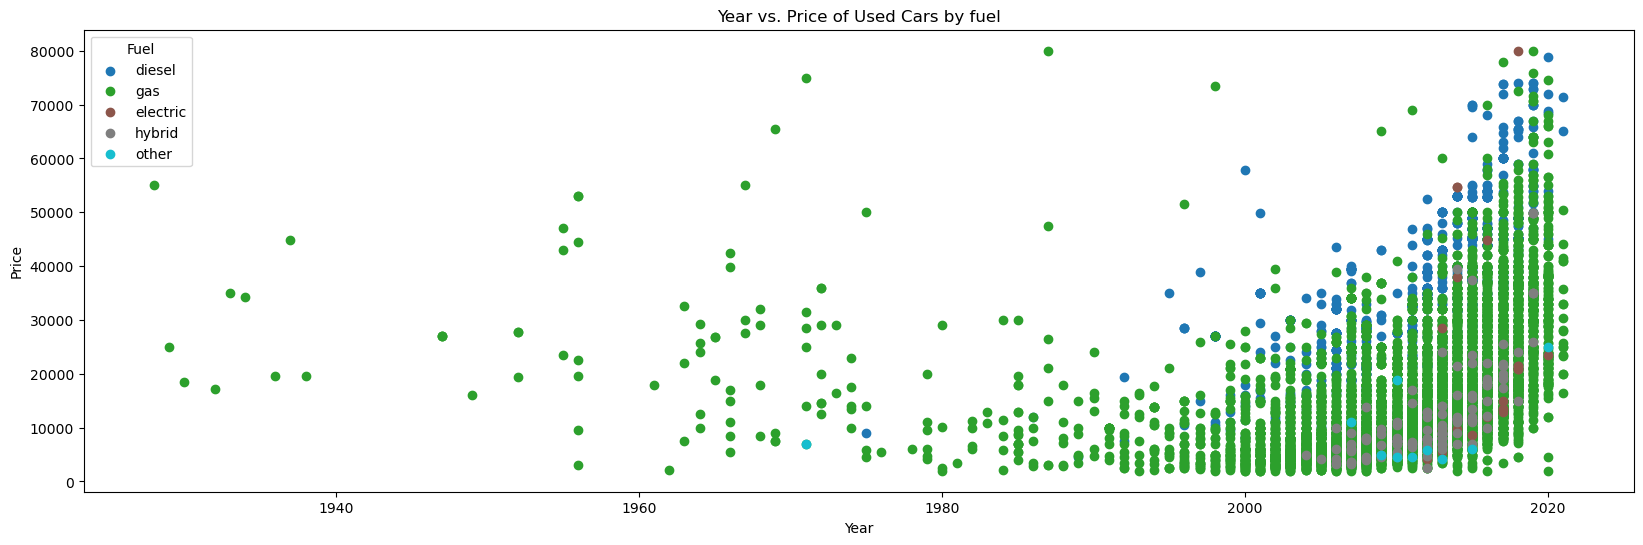

Unique paint_color: ['white' 'grey' 'green' 'red' 'silver' 'black' 'blue' 'custom' 'brown'
 'purple' 'orange' 'yellow']


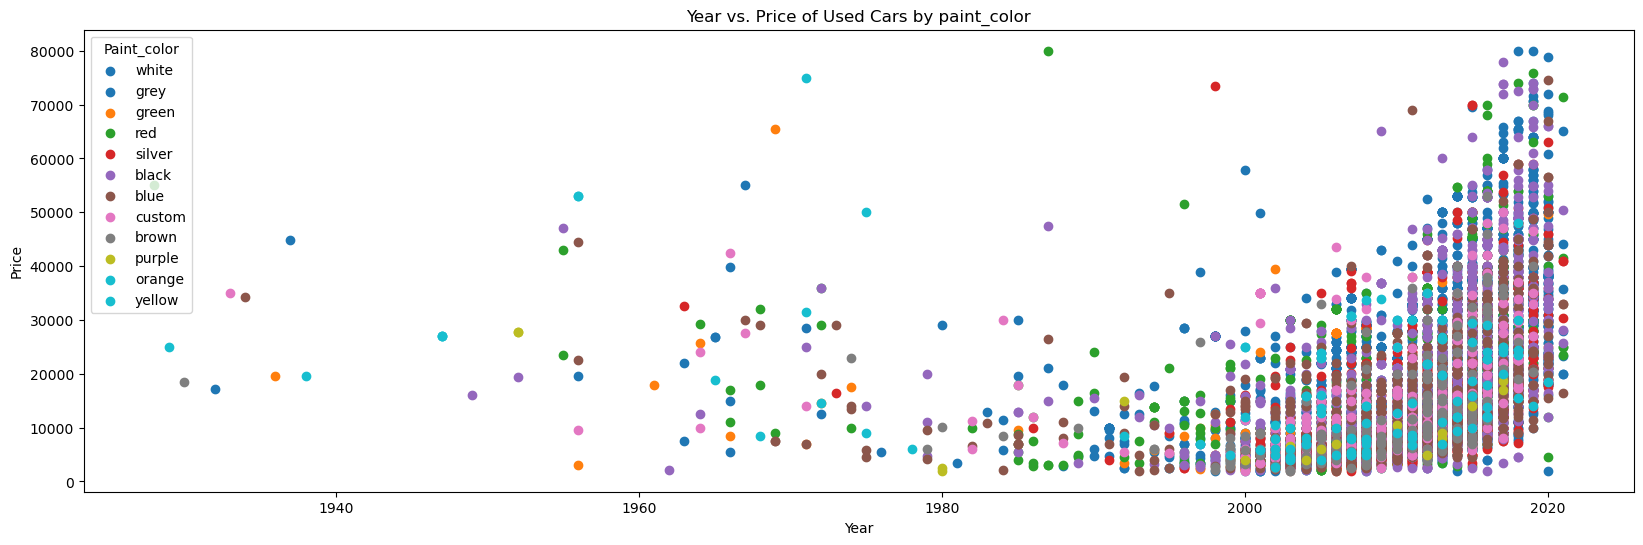



Unique models: ['super duty f-550 drw' 'santa fe sport' 'e500 4-matic' ... '240d'
 'cooper hardtop 2dr' 'town car black']


Unique region: ['hartford' 'cleveland' 'knoxville' 'south coast' 'sacramento' 'delaware'
 'tampa bay area' 'south florida' 'nashville' 'colorado springs' 'redding'
 'palm springs' 'ft myers / SW florida' 'wyoming' 'vermont' 'hawaii'
 'st cloud' 'oklahoma city' "spokane / coeur d'alene" 'milwaukee'
 'houston' 'rhode island' 'fayetteville' 'anchorage / mat-su' 'rochester'
 'greenville / upstate' 'wilmington' 'dallas / fort worth' 'louisville'
 'madison' 'mobile' 'charlotte' 'washington, DC' 'twin falls' 'lawton'
 'asheville' 'bakersfield' 'wichita' 'fargo / moorhead' 'st augustine'
 'topeka' 'salem' 'des moines' 'denver' 'albany' 'el paso' 'tulsa'
 'port huron' 'indianapolis' 'phoenix' 'st george' 'medford-ashland'
 'kansas city, MO' 'jacksonville' 'detroit metro' 'north jersey'
 'central NJ' 'scranton / wilkes-barre' 'eugene' 'boulder' 'roanoke'
 'boise' 'richmon

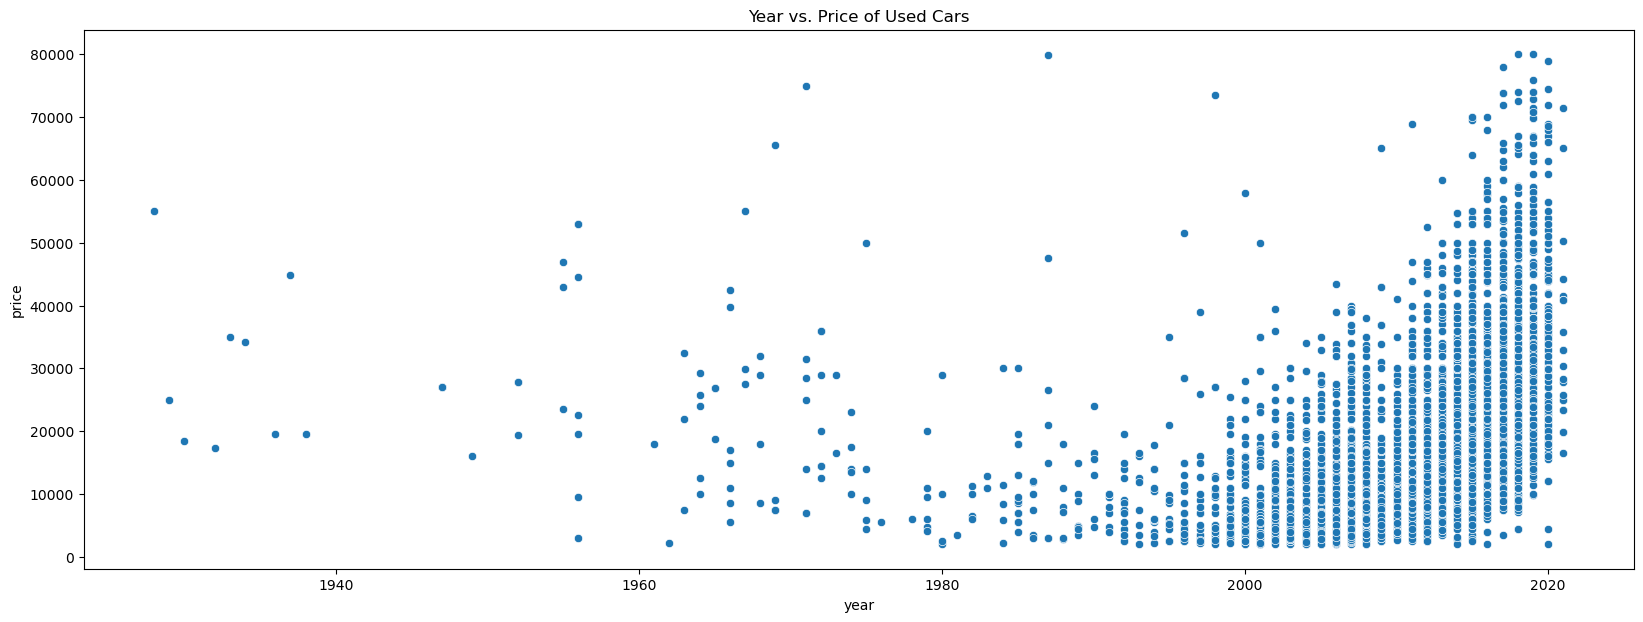

In [88]:
# Sample the data with plots for all categorical features
vehicles_sample = vehicles.sample(n=10000) if len(vehicles) > 10000 else vehicles

plt.figure(figsize=(25, 6))

def plot_scatter_by_category(df, category, title, x='year', y='price', figsize=(20, 6)):
    plt.figure(figsize=figsize)
    unique_categories = df[category].unique()
    print(f"Unique {category}: {unique_categories}")
    colors = plt.cm.get_cmap('tab10', len(unique_categories))
    
    for i, cat in enumerate(unique_categories):
        cat_data = df[df[category] == cat]
        plt.scatter(cat_data[x], cat_data[y], label=cat, color=colors(i))
    
    plt.title(f'Year vs. Price of Used Cars by {category}')
    plt.xlabel(x.capitalize())
    plt.ylabel(y.capitalize())
    plt.legend(title=category.capitalize())
    plt.show()

# Plot by 'size'
plot_scatter_by_category(vehicles_sample, 'size', 'Year vs. Price of Used Cars by Size', figsize=(20, 6))

# Plot by 'manufacturer'
plot_scatter_by_category(vehicles_sample, 'manufacturer', 'Year vs. Price of Used Cars by Manufacturer')

# Plot by 'type'
plot_scatter_by_category(vehicles_sample, 'type', 'Year vs. Price of Used Cars by Type', figsize=(20, 6))

# Plot by 'transmission'
plot_scatter_by_category(vehicles_sample, 'transmission', 'Year vs. Price of Used Cars by Transmission', figsize=(20, 6))

# Plot by 'condition'
plot_scatter_by_category(vehicles_sample, 'condition', 'Year vs. Price of Used Cars by Condition', figsize=(20, 6))

# Plot by 'cylinders'
plot_scatter_by_category(vehicles_sample, 'cylinders', 'Year vs. Price of Used Cars by Cylinders', figsize=(20, 6))

# Plot by 'title status'
plot_scatter_by_category(vehicles_sample, 'title_status', 'Year vs. Price of Used Cars by Title Status', figsize=(20, 6))

# Plot by 'state'
# plot_scatter_by_category(vehicles_sample, 'state', 'Year vs. Price of Used Cars by State')

# Plot by 'fuel'
plot_scatter_by_category(vehicles_sample, 'fuel', 'Year vs. Price of Used Cars by Fuel', figsize=(20, 6))

# Plot by 'paint_color'
plot_scatter_by_category(vehicles_sample, 'paint_color', 'Year vs. Price of Used Cars by Paint', figsize=(20, 6))


# Print unique models (# is large to plot)
unique_models = vehicles_sample['model'].unique()
print(f"\n\nUnique models: {unique_models}")

# Print unique region (# is large to plot)
unique_region = vehicles_sample['region'].unique()
print(f"\n\nUnique region: {unique_region}")

# Print unique state (# too large to plot)
unique_state = vehicles_sample['state'].unique()
print(f"\n\nUnique state: {unique_state}")



# Concluded that the relationship between Price and Year with category variables for more context is not linear

# Concluded: Scatter plot show that Price and Odometer relation is also not linear
plt.figure(figsize=[20, 7])
plt.title("Price and Odometer")
sns.scatterplot(x='odometer', y='price', data=vehicles_sample)
plt.title(f'Odometer vs. Price of Used Cars')
plt.show()

plt.figure(figsize=[20, 7])
plt.title("Price and Year")
sns.scatterplot(x='year', y='price', data=vehicles_sample)
plt.title(f'Year vs. Price of Used Cars')
plt.show()


In [36]:
vehicles.describe(include = 'all')

id   region          price          year manufacturer  \
count   3.486800e+04    34868   34868.000000  34868.000000        34868   
unique           NaN      392            NaN           NaN           41   
top              NaN  vermont            NaN           NaN         ford   
freq             NaN      695            NaN           NaN         7412   
mean    7.311508e+09      NaN   15837.446771   2011.176867          NaN   
std     4.299751e+06      NaN   13460.056823      7.162332          NaN   
min     7.301592e+09      NaN       0.000000   1905.000000          NaN   
25%     7.308189e+09      NaN    6500.000000   2008.000000          NaN   
50%     7.312225e+09      NaN   12000.000000   2013.000000          NaN   
75%     7.315136e+09      NaN   22003.500000   2016.000000          NaN   
max     7.317099e+09      NaN  155000.000000   2022.000000          NaN   

        model  condition    cylinders   fuel      odometer title_status  \
count   34868      34868        34868  34868  3.486800e+04        34868   
unique   5139          6            8      5           NaN            6   
top     f-150  excellent  6 cylinders    gas           NaN        clean   
freq      943      20059        11618  31313           NaN        33688   
mean      NaN        NaN          NaN    NaN  1.073991e+05          NaN   
std       NaN        NaN          NaN    NaN  9.990878e+04          NaN   
min       NaN        NaN          NaN    NaN  0.000000e+00          NaN   
25%       NaN        NaN          NaN    NaN  6.516400e+04          NaN   
50%       NaN        NaN          NaN    NaN  1.040000e+05          NaN   
75%       NaN        NaN          NaN    NaN  1.411678e+05          NaN   
max       NaN        NaN          NaN    NaN  9.999999e+06          NaN   

       transmission                VIN  drive       size   type paint_color  \
count         34868              34868  34868      34868  34868       34868   
unique            3              21938      3          4     13          12   
top       automatic  JTEBU5JR5G5317191    4wd  full-size    SUV       white   
freq          32476                 40  16565      20267   9278        9862   
mean            NaN                NaN    NaN        NaN    NaN         NaN   
std             NaN                NaN    NaN        NaN    NaN         NaN   
min             NaN                NaN    NaN        NaN    NaN         NaN   
25%             NaN                NaN    NaN        NaN    NaN         NaN   
50%             NaN                NaN    NaN        NaN    NaN         NaN   
75%             NaN                NaN    NaN        NaN    NaN         NaN   
max             NaN                NaN    NaN        NaN    NaN         NaN   

        state  
count   34868  
unique     51  
top        ca  
freq     3565  
mean      NaN  
std       NaN  
min       NaN  
25%       NaN  
50%       NaN  
75%       NaN  
max       NaN

In [89]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31278 entries, 215 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            31278 non-null  int64  
 1   region        31278 non-null  object 
 2   price         31278 non-null  int64  
 3   year          31278 non-null  float64
 4   manufacturer  31278 non-null  object 
 5   model         31278 non-null  object 
 6   condition     31278 non-null  object 
 7   cylinders     31278 non-null  object 
 8   fuel          31278 non-null  object 
 9   odometer      31278 non-null  float64
 10  title_status  31278 non-null  object 
 11  transmission  31278 non-null  object 
 12  VIN           31278 non-null  object 
 13  drive         31278 non-null  object 
 14  size          31278 non-null  object 
 15  type          31278 non-null  object 
 16  paint_color   31278 non-null  object 
 17  state         31278 non-null  object 
dtypes: float64(2), int64(2), obj


After removing outliers, length of data-set: 31278


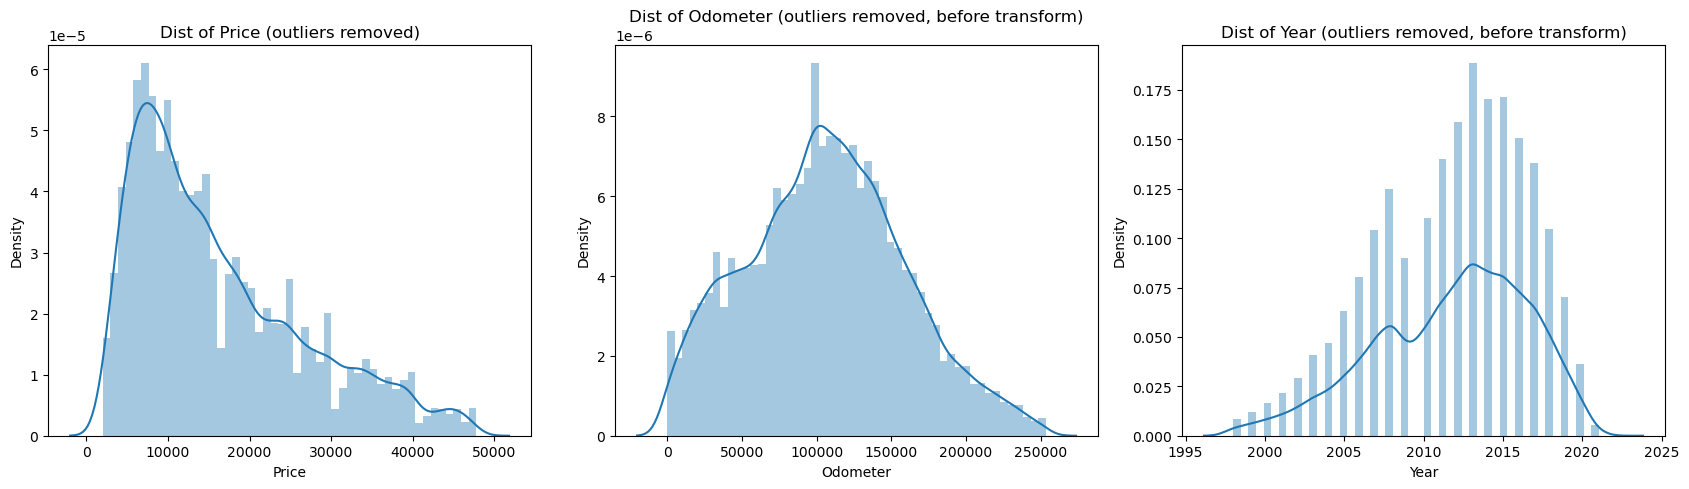

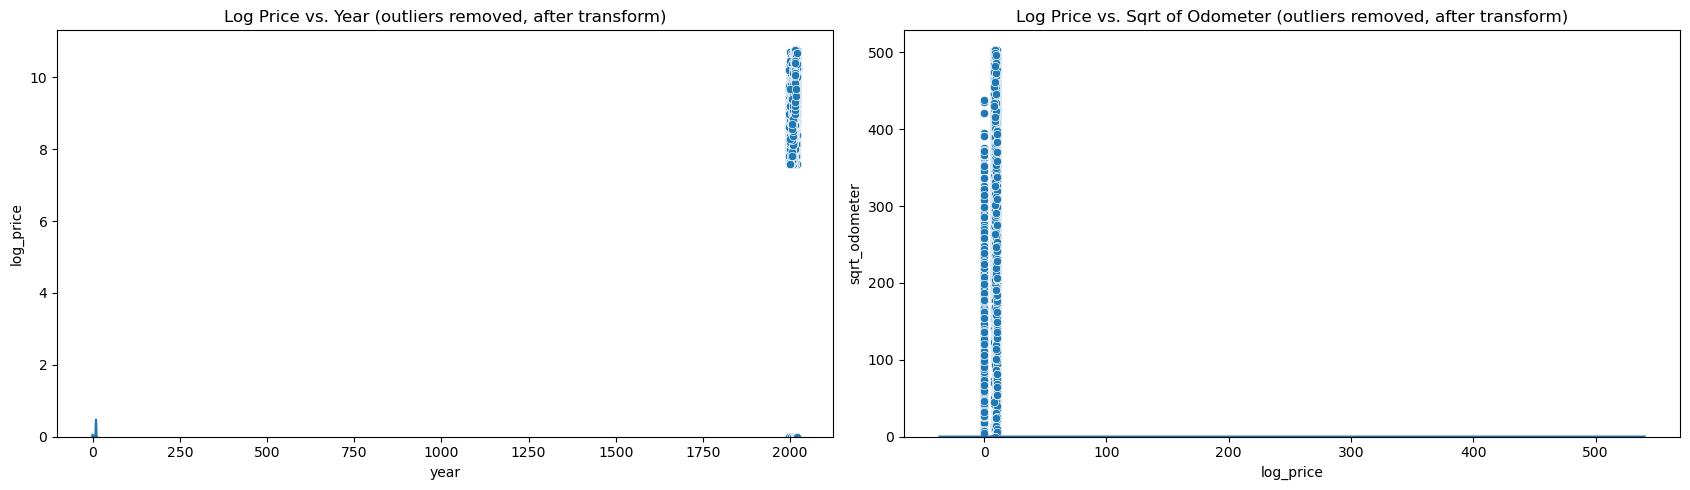


After removing outliers and with transforms on numerics, length of data-set: 31278


In [90]:
# Function to remove outliers using IQR method
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]

# Apply outlier removal and copy existing to new with outliers removed
vehicles_no_outliers = vehicles.copy()

# Remove outliers in 'price' and 'odometer'
vehicles_no_outliers['price'] = remove_outliers(vehicles_no_outliers['price'])
vehicles_no_outliers['odometer'] = remove_outliers(vehicles_no_outliers['odometer'])
vehicles_no_outliers['year'] = remove_outliers(vehicles_no_outliers['year'])

# Size of data-set now after removing any price and odometer outliers
print(f"\nAfter removing outliers, length of data-set: {len(vehicles_no_outliers)}")


# Apply transformations to data-set with outliers removed
vehicles_transformed = vehicles_no_outliers.copy()

# Log Transformation of 'price' (handling zeros)
vehicles_transformed['log_price'] = np.log(vehicles_transformed['price'] + 1).fillna(0)  # Adding 1 to avoid log(0)

# Square Root Transformation of 'odometer' (handling NaN and negative values)
vehicles_transformed['sqrt_odometer'] = np.sqrt(vehicles_transformed['odometer'].fillna(0))  # Handling NaN and avoiding negative sqrt

# Distribution Plot with KDE using Seaborn
plt.figure(figsize=[17, 5])

# Plot for Price w outliers removed
plt.subplot(1, 3, 1)
sns.distplot(vehicles_no_outliers['price'], kde=True)
plt.title('Dist of Price (outliers removed)')
plt.xlabel('Price')
plt.ylabel('Density')

# Plot for Odometer w outliers removed
plt.subplot(1, 3, 2)
sns.distplot(vehicles_no_outliers['odometer'], kde=True)
plt.title('Dist of Odometer (outliers removed, before transform)')
plt.xlabel('Odometer')
plt.ylabel('Density')

# Plot for Year w outliers removed
plt.subplot(1, 3, 3)
sns.distplot(vehicles_no_outliers['year'], kde=True)
plt.title('Dist of Year (outliers removed, before transform)')
plt.xlabel('Year')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=[17, 5])
plt.subplot(1, 2, 1)
sns.distplot(vehicles_transformed['log_price'], kde=True)
plt.title('Dist of Log Transformed Price (outliers removed, after transform)')
plt.xlabel('Price')
plt.ylabel('Density')

# Plot for Square Root Transformed Odometer
plt.subplot(1, 2, 2)
sns.distplot(vehicles_transformed['sqrt_odometer'], kde=True)
plt.title('Dist of Sqrt Transformed Odometer (outliers removed, after transform)')
plt.xlabel('Odometer')
plt.ylabel('Density')

# Plot for Log Transformed Price vs. Year
plt.subplot(1, 2, 1)
sns.scatterplot(x = 'year', y = 'log_price', data = vehicles_transformed)
plt.title('Log Price vs. Year (outliers removed, after transform)')
plt.xlabel('year')
plt.ylabel('log_price')

# Plot for Log Transformed Price vs. Odometer
plt.subplot(1, 2, 2)
sns.scatterplot(x = 'log_price', y = 'sqrt_odometer', data = vehicles_transformed)
plt.title('Log Price vs. Sqrt of Odometer (outliers removed, after transform)')
plt.xlabel('log_price')
plt.ylabel('sqrt_odometer')


plt.tight_layout()
plt.show()

print(f"\nAfter removing outliers and with transforms on numerics, length of data-set: {len(vehicles_transformed)}")

# CONCLUSION: Removing the outliers does not change either of the distribution much. This means the price range filter was effective.
# CONCLUSION: Log Transformation of Price and a Sqrt Transformation of Odometer does not seem to normalize the distributions of these numeric features any more than without any transform

# CONCLUSION: Log Transformed Price does not show any linear relationship of Price with Year or Price with Odometer. 

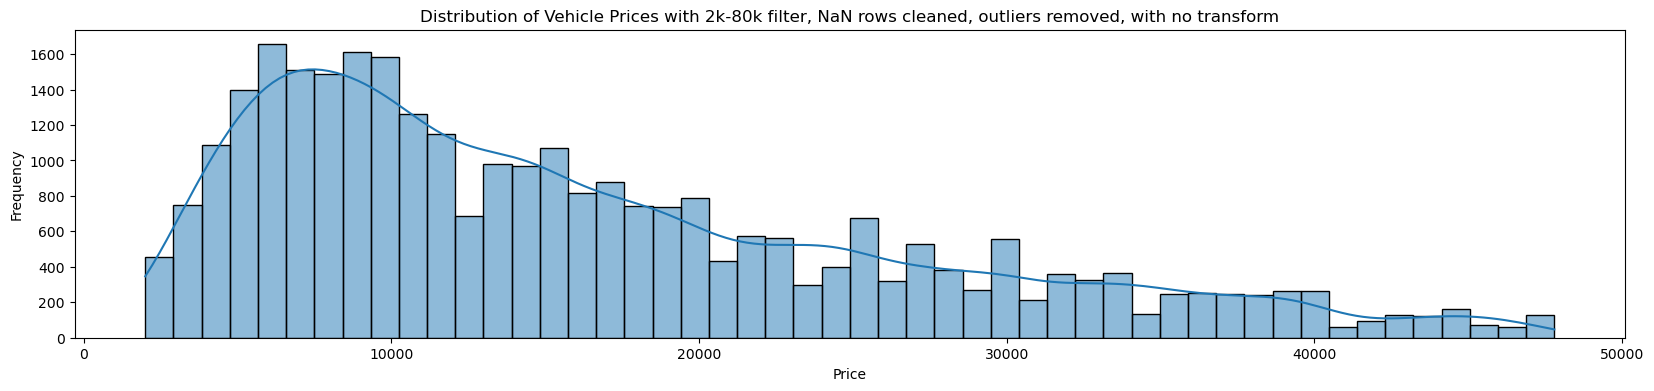

In [91]:
# Double check price distribution, plot a histogram of vehicles_no_outliers prices data-set 
plt.figure(figsize=(20, 4))
sns.histplot(vehicles_no_outliers['price'], bins=50, kde=True)  
plt.title('Distribution of Vehicle Prices with 2k-80k filter, NaN rows cleaned, outliers removed, with no transform')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [92]:
vehicles_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31278 entries, 215 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            31278 non-null  int64  
 1   region        31278 non-null  object 
 2   price         30341 non-null  float64
 3   year          30380 non-null  float64
 4   manufacturer  31278 non-null  object 
 5   model         31278 non-null  object 
 6   condition     31278 non-null  object 
 7   cylinders     31278 non-null  object 
 8   fuel          31278 non-null  object 
 9   odometer      30941 non-null  float64
 10  title_status  31278 non-null  object 
 11  transmission  31278 non-null  object 
 12  VIN           31278 non-null  object 
 13  drive         31278 non-null  object 
 14  size          31278 non-null  object 
 15  type          31278 non-null  object 
 16  paint_color   31278 non-null  object 
 17  state         31278 non-null  object 
dtypes: float64(3), int64(1), obj

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [41]:
# Some Data Preparation already completed above.

# Dropping category columns like models and region where # of unique values is too many. 
# Instead, will use manufacturer and state for similar information
# Dropping unique identifiers like id and VIN as well.
vehicles_dropped = vehicles_no_outliers.drop(columns=['model', 'region', 'id', 'VIN'])

# Cleaning the 'cylinders' column to contain only numeric values
vehicles_dropped['cylinders'] = vehicles_dropped['cylinders'].str.extract('(\d+)', expand=False)

# Converting the extracted numeric value to integers
vehicles_dropped['cylinders'] = vehicles_dropped['cylinders'].astype(float)
vehicles_dropped['cylinders'] = pd.to_numeric(vehicles_dropped['cylinders'], errors='coerce')

print(vehicles_dropped.info())

# Drop any rows with NaN in numeric feature columns
numeric_features = ['price', 'odometer', 'year', 'cylinders']
vehicles_dropped.dropna(subset=numeric_features, inplace = True)

# Drop any rows with NaN in categorical feature columns 
# Define categorical features
categorical_features = ['size', 'manufacturer', 'fuel', 'title_status', 'type', 'transmission', 'condition', 'drive', 'paint_color', 'state']
vehicles_dropped.dropna(subset=categorical_features, inplace = True)


<class 'pandas.core.frame.DataFrame'>
Index: 34868 entries, 126 to 426836
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         33614 non-null  float64
 1   year          34095 non-null  float64
 2   manufacturer  34868 non-null  object 
 3   condition     34868 non-null  object 
 4   cylinders     34772 non-null  float64
 5   fuel          34868 non-null  object 
 6   odometer      34516 non-null  float64
 7   title_status  34868 non-null  object 
 8   transmission  34868 non-null  object 
 9   drive         34868 non-null  object 
 10  size          34868 non-null  object 
 11  type          34868 non-null  object 
 12  paint_color   34868 non-null  object 
 13  state         34868 non-null  object 
dtypes: float64(4), object(10)
memory usage: 4.0+ MB
None


In [90]:
# Checking multi-collinearity with VIF (using only numerical features)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vehicles_dropped_copy = vehicles_dropped[['price', 'odometer', 'year', 'cylinders']]

# Define preprocessing steps for numeric features
numeric_features = ['price', 'odometer', 'year', 'cylinders']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())                    # Standardize features
])


# Create ColumnTransformer with only numeric_transformer
# No Log Transforms applied since earlier section showed log transformed price has NO linear relation with odomoter or year
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features) 
    ]
)

# Fit and transform to get the transformed data
transformed_data = preprocessor.fit_transform(vehicles_dropped_copy)

# Create DataFrame from numeric transformed data
transformed_df = pd.DataFrame(transformed_data, columns=numeric_features)

# Function to calculate VIF for numeric variables
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for numeric features in transformed_df
numeric_data = transformed_df[numeric_features]

vif_data = calculate_vif(numeric_data)
print("Variance Inflation Factor (VIF):")
print(vif_data)



# Conclusion:

Variance Inflation Factor (VIF):
     feature       VIF
0      price  1.366709
1   odometer  1.406601
2       year  1.513764
3  cylinders  1.188264


In [93]:
# Define preprocessing steps for numeric features 
numeric_features = ['price', 'odometer', 'year', 'cylinders']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute missing values with median
    ('poly', PolynomialFeatures(degree=2)),        # Polynomial feature generation with degree 2
])

# Define preprocessing steps for categorical features
categorical_features = ['size', 'manufacturer', 'fuel', 'title_status', 'type', 'transmission', 'condition', 'drive', 'paint_color', 'state']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode categorical features
])

# Create ColumnTransformer with both numeric and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform to get the transformed data
transformed_data = preprocessor.fit_transform(vehicles_dropped)

# Convert transformed data to a dense array
transformed_data_dense = transformed_data.toarray()

# Create DataFrame from transformed data
numeric_columns = numeric_features
categorical_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
numeric_feature_names = preprocessor.named_transformers_['num']['poly'].get_feature_names_out(numeric_columns)
all_columns = list(numeric_feature_names) + list(categorical_columns)

vehicles_copy_transformed = pd.DataFrame(transformed_data_dense, columns=all_columns)


# Display features from the transforms applied 
from tabulate import tabulate
# Convert the columns into a tabular format
table = [[f'Column {i+1}', column] for i, column in enumerate(all_columns)]

print(f"\nALL Features (count, excluding first): {len(all_columns) - 1}")
# print(tabulate(table, headers=['Index', 'Feature Name']))



ALL Features (count, excluding first): 157


In [94]:
vehicles_copy_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32460 entries, 0 to 32459
Columns: 158 entries, 1 to state_wy
dtypes: float64(158)
memory usage: 39.1 MB


In [43]:
# Compute all correlation with 'price'
correlations = vehicles_copy_transformed.corr()['price'].sort_values(ascending=False)

# Select top 30 features correlated with 'price' (excluding 'price' itself)
top_30_features = correlations.head(31)[1:]

# Compute correlation matrix for the top 30 features
correlation_matrix = vehicles_copy_transformed[top_30_features.index].corr()
#print(correlation_matrix.head())

# Create a heatmap with annotations for both rows and columns
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, annot_kws={"size": 10})

plt.title('Top 30 Correlation with Price (Excluding Price)')
plt.show()

### Modeling

With your (almost) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Train MSE: 378.4257978965183
Test MSE: 394.9724141524779


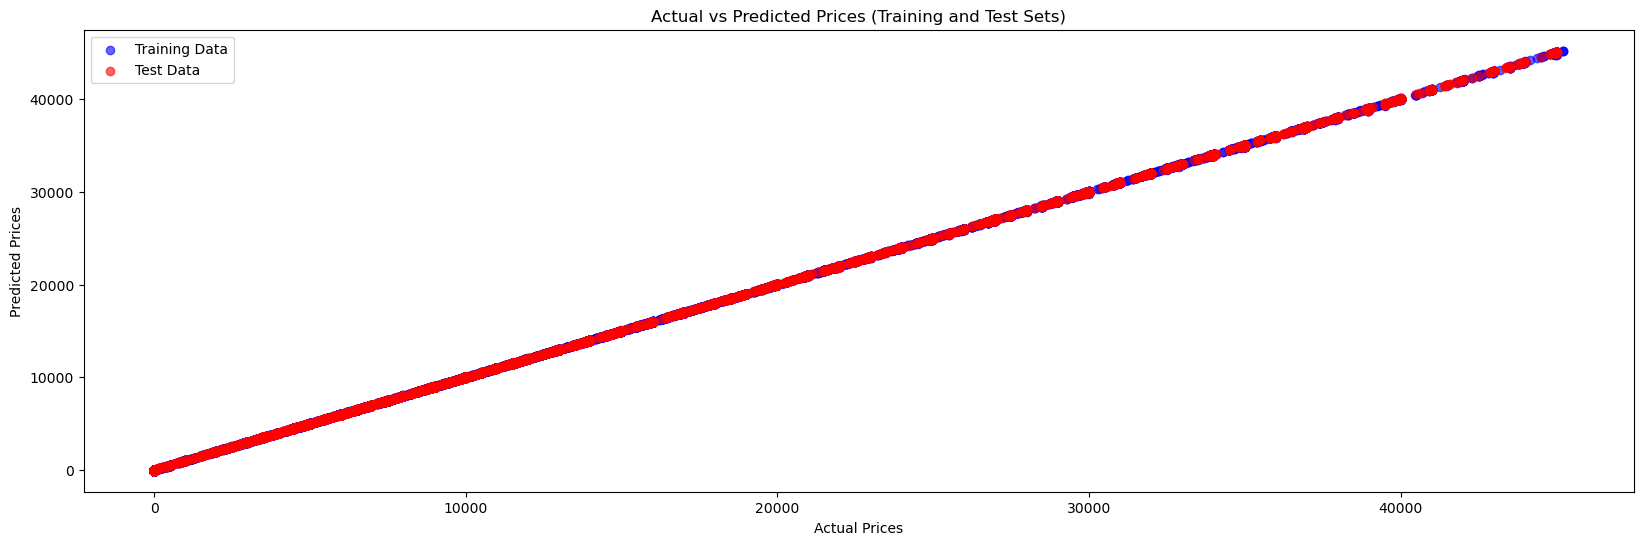

In [95]:
# Model Building 0: Basic - with top_30_features correlated to price

# Top 20 features selected that are highly correlated to price - excluding price itself
top_30_features = correlations.head(31)[1:]
selected_features = top_30_features.index.tolist()

X0 = vehicles_copy_transformed[selected_features]
y0 = vehicles_copy_transformed['price']

# Split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.2, random_state=42)

# Preprocess data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Ridge regression model with alpha = 1
ridge_model = Ridge(alpha=1)  
ridge_model.fit(X_train, y_train)

# Prediction with Ridge
train_predictions = ridge_model.predict(X_train)
test_predictions = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# Combined scatter plot for training and test sets
plt.figure(figsize=(20, 6))
plt.scatter(y_train, train_predictions, alpha=0.6, color='b', label='Training Data')
plt.scatter(y_test, test_predictions, alpha=0.6, color='r', label='Test Data')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Training and Test Sets)')
plt.legend()
plt.show()
# Conclusion - the difference between train MSE (305.21) and test MSE (300.08) is not very large, 
# suggesting model is performing reasonably well on the training data, it's also performing similarly
# on the test data with moderate variance.

# Need to see if this model can be improved in reducing both bias and variance for better generalization.

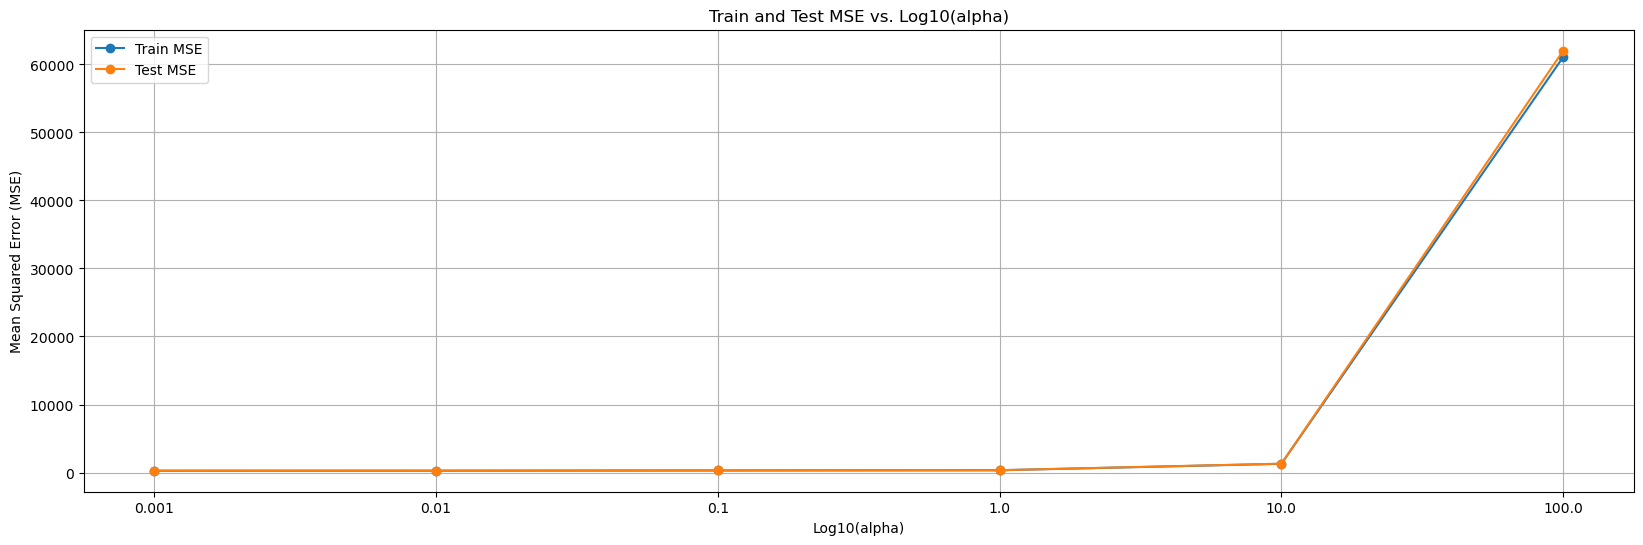

Best Ridge Model metrics...

Best alpha: 0.001

Best Train MSE: 264.82

Best Test MSE: 271.98

Train MSE: 265.29658931498426

Test MSE: 286.88246690566456

Feature coefficients (in descending order, both positive and negative impact features affecting price)
                     Feature  Coefficient
                  price year 10841.875622
                        year  3880.214929
                   cylinders  3207.685754
               odometer year   463.615722
              price odometer    16.298668
             price cylinders    10.420452
                 cylinders^2     7.814927
                  odometer^2     5.913587
                 fuel_diesel     3.187234
                  type_truck     1.972867
                    state_ok     1.896870
     manufacturer_mitsubishi     1.448635
   manufacturer_aston-martin     1.387466
         transmission_manual     1.123729
        manufacturer_porsche     1.016652
            type_convertible     0.885842
                    state_a

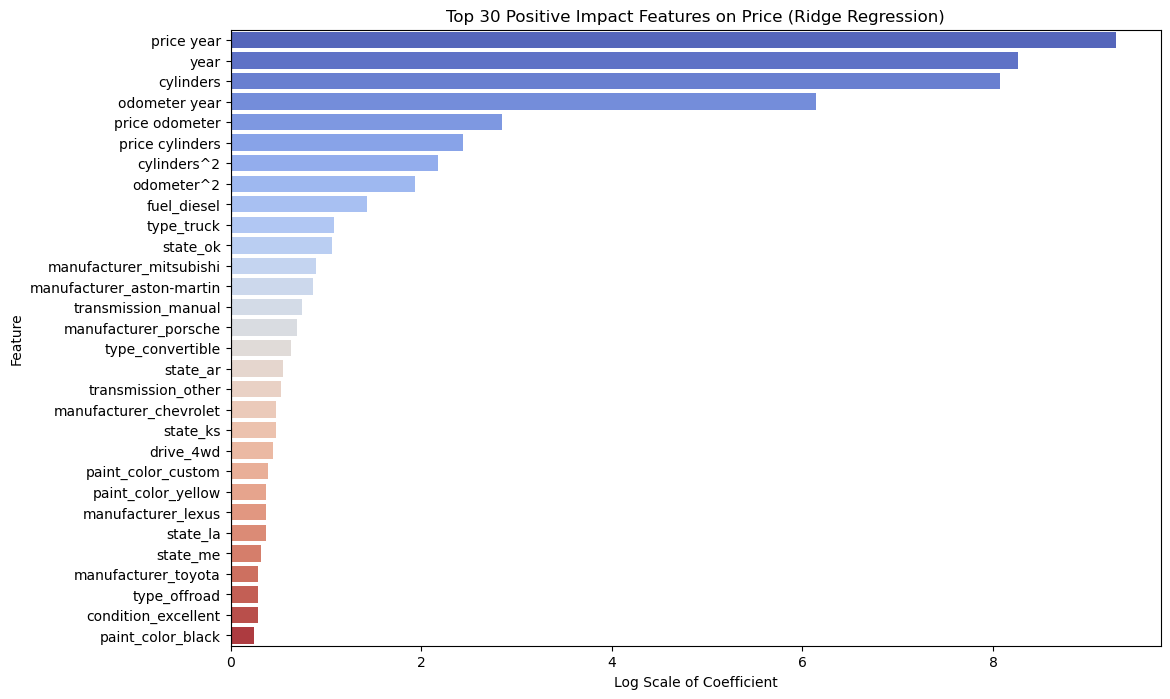

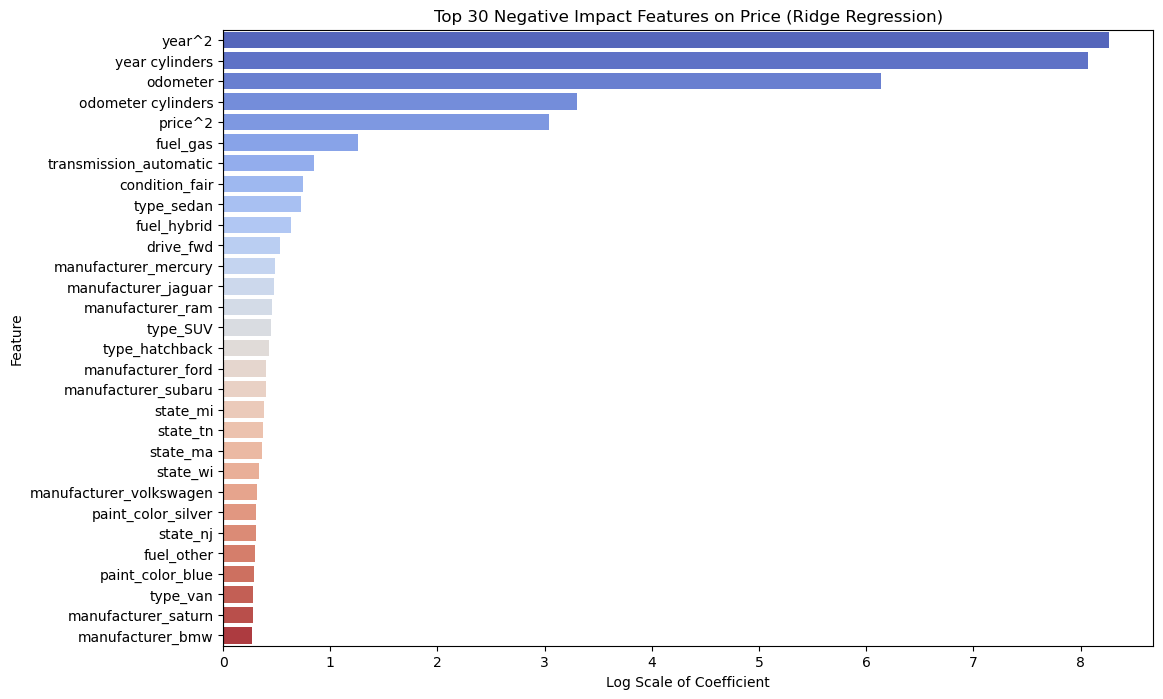

In [45]:
# Model Build 1: Start with all features with feature selection and model build with Ridge Regression

# Used Ridge regression with the large # of features as it includes regularization 
# that penalizes large coefficients, effectively shrinking less important features towards zero.

# Target variable = price
X = vehicles_copy_transformed.drop('price', axis =1)
y = vehicles_copy_transformed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

ridge = Ridge()

# Define a Pipeline with StandardScaler and Ridge Regression
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge)
])

# Define the hyper-parameter grid for Ridge Regression
# ridge_param_dict = {'ridge__alpha' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 10000.0]}
ridge_param_dict = {'ridge__alpha': np.logspace(-3, 2, num=6)}

# This will create alpha values from 0.001 to 100 

# Set up GridSearchCV with this ridge_pipe and ridge_param_dict
ridge_grid = GridSearchCV(estimator = ridge_pipe, param_grid = ridge_param_dict, scoring='neg_mean_squared_error', return_train_score=True, cv=5)


# Fit the Grid Search to the train data
ridge_grid.fit(X_train, y_train)


# Get best model estimator
best_ridge_model = ridge_grid.best_estimator_

# Access the Ridge regression model within the pipeline
ridge_model = best_ridge_model.named_steps['ridge']

# Get coefficients (weights) and intercept
coefficients = ridge_model.coef_
intercept = ridge_model.intercept_
best_alpha = ridge_grid.best_params_['ridge__alpha']

# Evaluate on training set
y_train_pred = best_ridge_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

# Evaluate on test set
y_test_pred = best_ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Extract results from GridSearchCV's cv_results_
results = ridge_grid.cv_results_
alphas = ridge_param_dict['ridge__alpha']
train_mses = -results['mean_train_score']
test_mses = -results['mean_test_score']

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(np.log10(alphas), train_mses, label='Train MSE', marker='o')
plt.plot(np.log10(alphas), test_mses, label='Test MSE', marker='o')
plt.title('Train and Test MSE vs. Log10(alpha)')
plt.xlabel('Log10(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(np.log10(alphas), labels=[str(alpha) for alpha in alphas])
plt.legend()
plt.grid(True)
plt.show()


# Extract parameter grid and mean test scores and mean train scores
param_alpha = results['param_ridge__alpha']
mean_test_scores = results['mean_test_score']
mean_train_scores = results['mean_train_score']

# Find the index of the best mean test score
best_index = np.argmax(mean_test_scores)

# Extract the best mean test AND train score and its corresponding alpha
best_mean_test_score = mean_test_scores[best_index]
best_mean_train_score = mean_train_scores[np.argmax(mean_train_scores)]
best_alpha = param_alpha[best_index]

# Convert the negative mean test score to positive (actual MSE)
best_test_mse = -best_mean_test_score
# Convert the negative mean train score to positive (actual MSE)
best_train_mse = -best_mean_train_score


# Ridge model metrics
print("Best Ridge Model metrics...")
print(f"\nBest alpha: {best_alpha}")
print(f"\nBest Train MSE: {best_train_mse:.2f}")
print(f"\nBest Test MSE: {best_test_mse:.2f}")
print(f"\nTrain MSE: {train_mse}")
print(f"\nTest MSE: {test_mse}")


# Create a DataFrame to store coefficients
columns = X_train.columns 
ridge_coefficients_df = pd.DataFrame({'Feature': columns, 'Coefficient': coefficients})

# Sort coefficients in descending order
ridge_coefficients_df = ridge_coefficients_df.sort_values(by='Coefficient', ascending=False)

# Print Positive, Negative impact Feature coefficients in a table format
print("\nFeature coefficients (in descending order, both positive and negative impact features affecting price)")
print(ridge_coefficients_df.to_string(index=False))


# Separate positive and negative coefficients
positive_coeffs = ridge_coefficients_df[ridge_coefficients_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(30)
negative_coeffs = ridge_coefficients_df[ridge_coefficients_df['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(30)

# Plotting positive and negative feature coefficients with log scale
plt.figure(figsize=(12, 8))

# Positive coefficients
sns.barplot(x=np.log1p(positive_coeffs['Coefficient']), y='Feature', data=positive_coeffs, palette='coolwarm')
plt.xlabel('Log Scale of Coefficient')
plt.title('Top 30 Positive Impact Features on Price (Ridge Regression)')
plt.axvline(x=0, color='k', linestyle='--')  # Add vertical line at zero

plt.figure(figsize=(12, 8))

# Negative coefficients
sns.barplot(x=np.log1p(-negative_coeffs['Coefficient']), y='Feature', data=negative_coeffs, palette='coolwarm')
plt.xlabel('Log Scale of Coefficient')
plt.title('Top 30 Negative Impact Features on Price (Ridge Regression)')
plt.axvline(x=0, color='k', linestyle='--')  # Add vertical line at zero
plt.show()

# Conclusion: With Train and Test MSE for best ridge model low and close to each other, likely model is performing well 
# on both the training and test datasets. 
# This indicates that this best Ridge model has selected the features without significant overfitting or underfitting. 

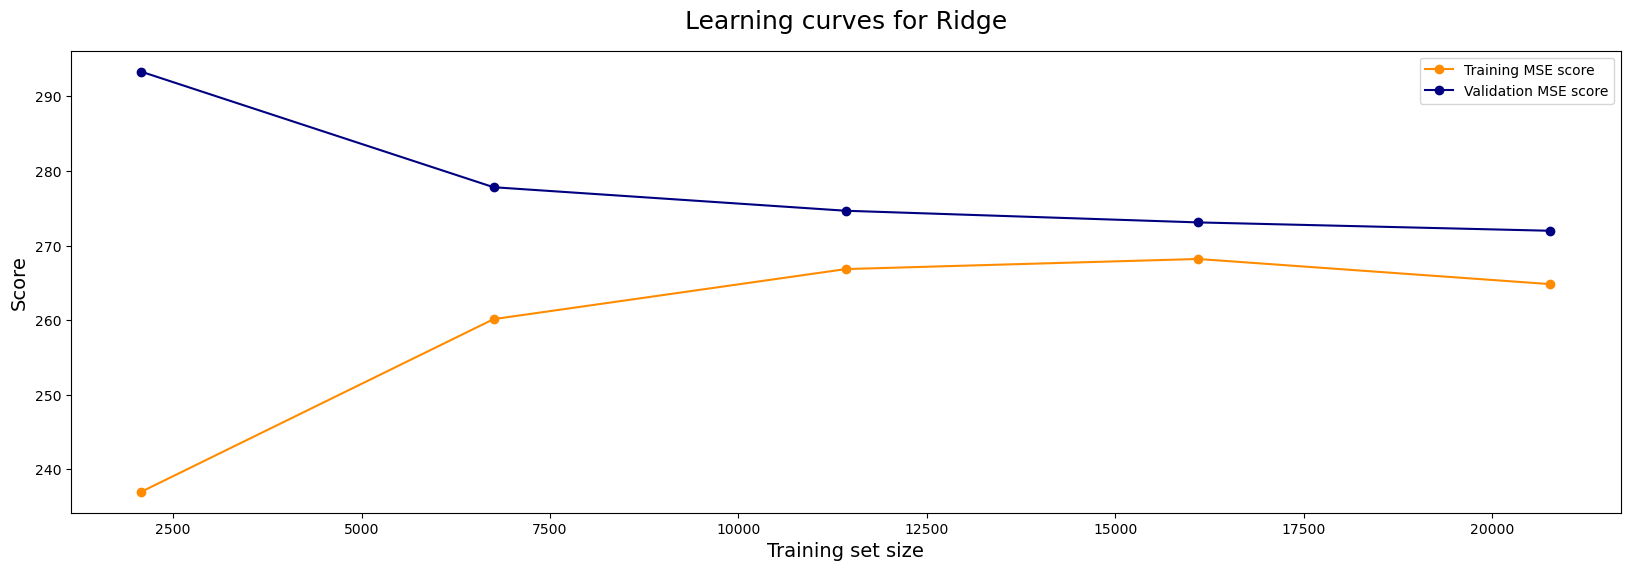

In [46]:
# Model Build 2: More Evaluation with Learning curves against ridge_grid with configs as below. this ridge_grid uses a 5-fold cross validation
# ridge_grid = GridSearchCV(estimator = ridge_pipe, param_grid = ridge_param_dict, scoring='neg_mean_squared_error', return_train_score=True)

train_sizes, train_scores, test_scores = learning_curve(
        ridge_grid,
        X_train,
        y_train
    )
train_scores_mean = np.mean(-train_scores, axis=1) 
test_scores_mean = np.mean(-test_scores, axis=1)

plt.figure(figsize=(20, 6))
plt.plot(train_sizes, train_scores_mean, label="Training MSE score", color="darkorange", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation MSE score", color="navy", marker='o')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

# Conclusion: Supports the above conclusion that the model has no overfitting or underfitting 

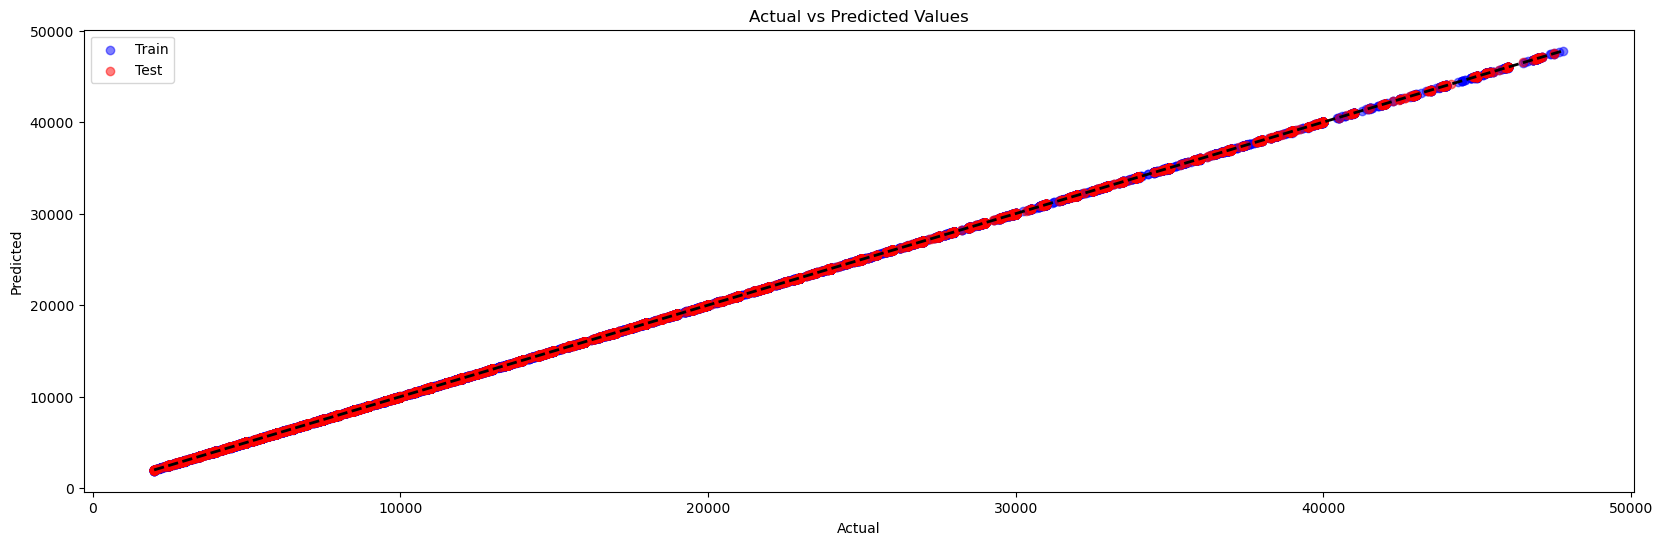

In [23]:
# Model 2 Evaluation - Combined plot of Actual vs Predicted values for Train and Test sets
plt.figure(figsize=(20, 6))

plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train', color='blue')
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test', color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

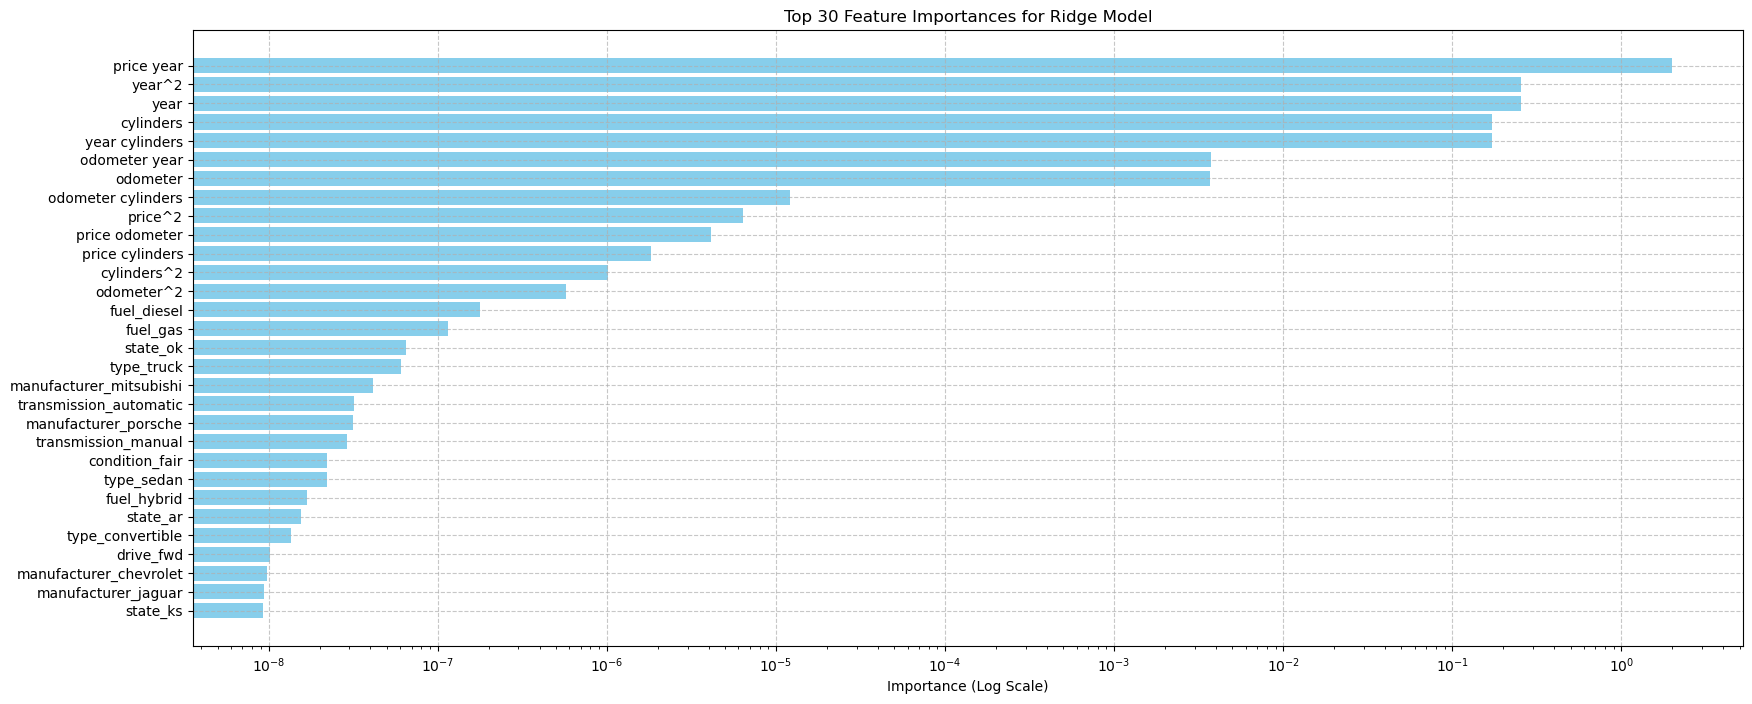

In [47]:
# Model Build 2 Evaluation - Compute permutation importance for Model2
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Compute permutation importance
result_perm_importance = permutation_importance(best_ridge_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importances
importance = result_perm_importance.importances_mean

# Combine feature names and their importances
feature_importances = list(zip(X_test.columns, importance))

# Sort feature importances by importance value in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Extract top 30 features
top_features = feature_importances[:30]

# Extract feature names and importance values for plotting
top_feature_names = [feature[0] for feature in top_features]
top_feature_importances = [feature[1] for feature in top_features]

# Plotting the feature importances using matplotlib
plt.figure(figsize=(20, 8))
plt.barh(top_feature_names, top_feature_importances, color='skyblue')
plt.xlabel('Importance (Log Scale)')
plt.title('Top 30 Feature Importances for Ridge Model')
plt.xscale('log')         # Use logarithmic scale for the x-axis
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

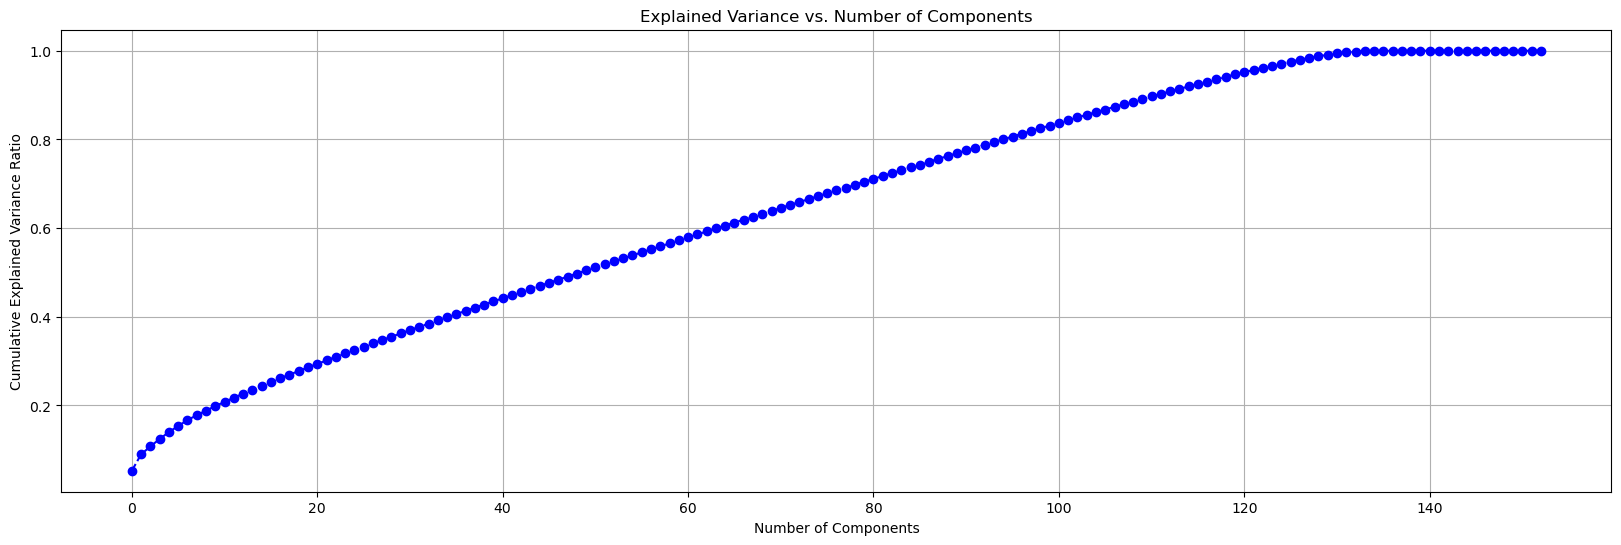

Number of components to retain 90% variance: 112


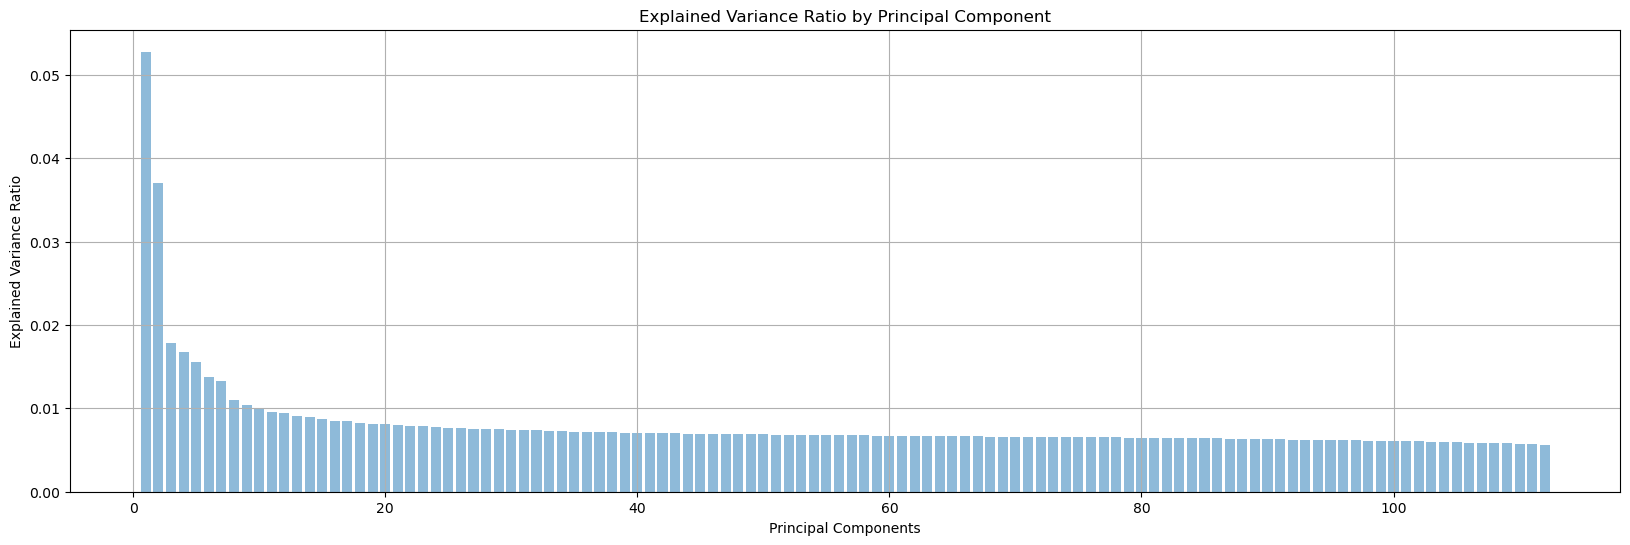

In [26]:
# Model Build 3: Dimensionality Reduction with PCA. Attempts to reduce number of features with as much variance as possible

# Exploring how many components is needed for a 40-80% variance
# Applying PCA to compute all components
from sklearn.decomposition import PCA

# Work with column transforms from before 
X_pca = vehicles_copy_transformed.drop('price', axis = 1)
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Fit PCA and compute explained variance ratio
pca = PCA()
pca.fit(X_pca_scaled)

# Plot cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(20, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Determine the number of components to keep
n_components = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Transform data to the chosen number of components
pca = PCA(n_components=n_components)
X_pca_transform = pca.fit_transform(X_pca_scaled)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Plot explained variance for each component
plt.figure(figsize=(20, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.grid(True)
plt.show()



Best number of components: 120
Best alpha: 0.001
Train MSE: 4582593.336968285
Test MSE: 4582410.925240905


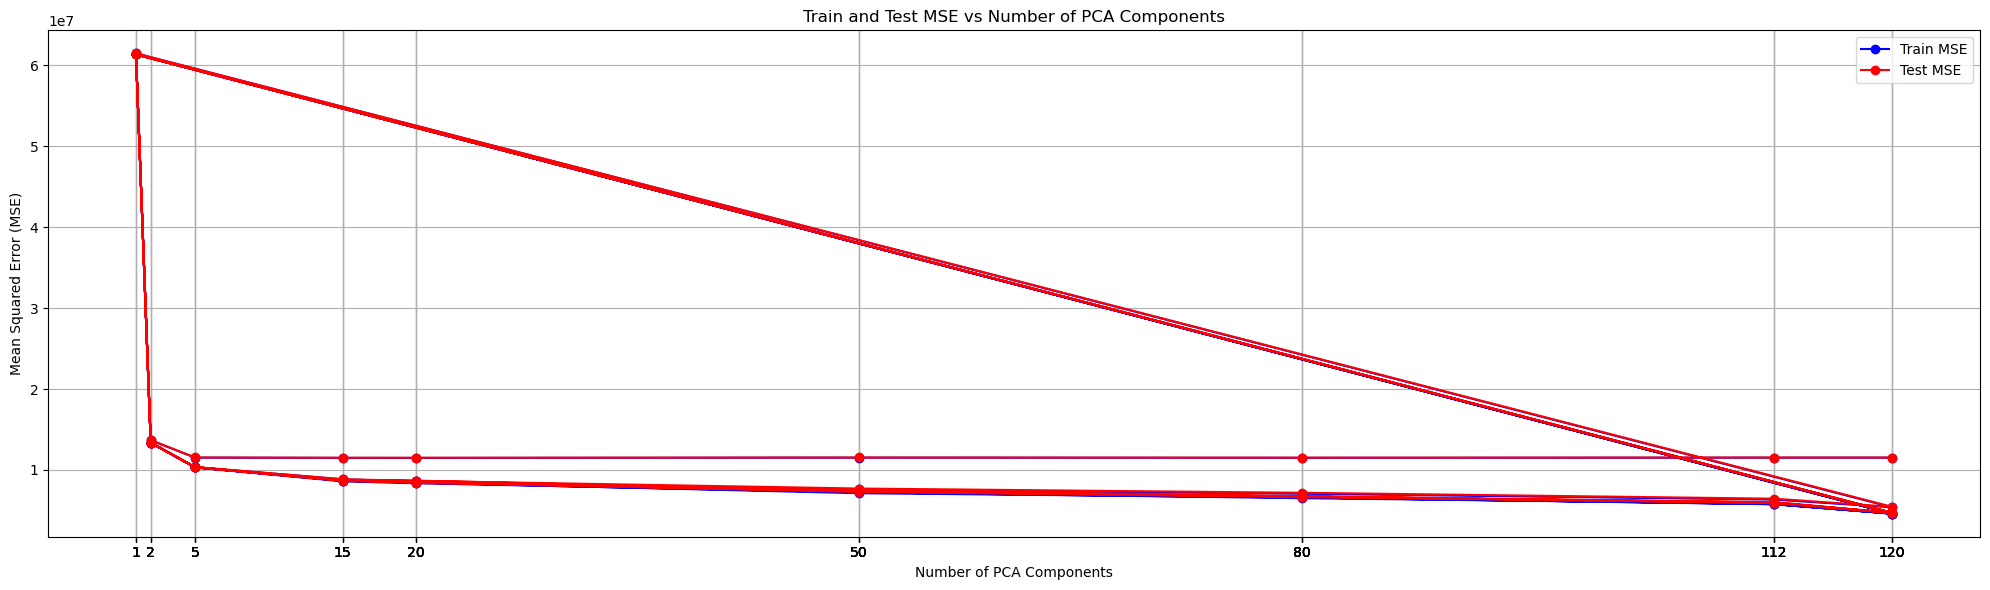

In [27]:
# Proceeds to build the model using Lasso Regression to work on a PCA transformed data-set 
# Uses PCA for dimensionality reduction and Lasso regression for regularization
# This model has a very high train and test MSE and hence not viable for our price prediction


# Define the features and target
X = vehicles_copy_transformed.drop('price', axis=1)
y = vehicles_copy_transformed['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with StandardScaler, PCA, and LassoRegression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lasso', Lasso())
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': [1, 2, 5, 15, 20, 50, 80, 112, 120],
    'lasso__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]      # Different alpha values for Lasso regression
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model and best params
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the training and test sets
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Best number of components: {best_params['pca__n_components']}")
print(f"Best alpha: {best_params['lasso__alpha']}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


# Plotting train and test MSE values
components_list = [param['pca__n_components'] for param in grid_search.cv_results_['params']]
train_mse_values = -grid_search.cv_results_['mean_train_score']
test_mse_values = -grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(20, 6))
plt.plot(components_list, train_mse_values, marker='o', linestyle='-', color='b', label='Train MSE')
plt.plot(components_list, test_mse_values, marker='o', linestyle='-', color='r', label='Test MSE')
plt.title('Train and Test MSE vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(components_list)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Best number of PCA components: 120
Best number of clusters: 4
Best Ridge alpha: 10
Train MSE: 4711515.089223165
Test MSE: 4704314.930125985


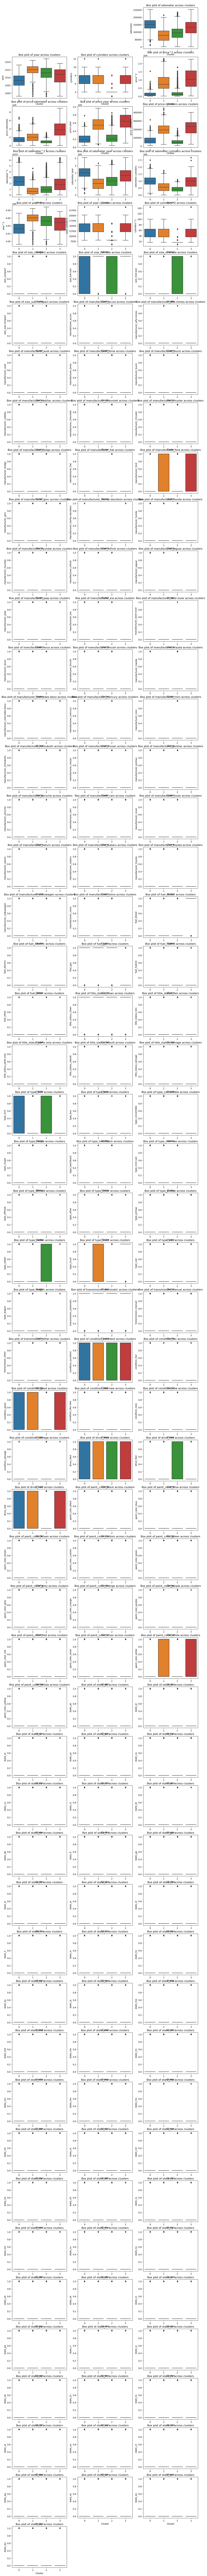

In [30]:
# Model Build 4: 

from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import math

# Custom transformer to add cluster labels as features
class ClusterLabelsAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        self.labels_ = self.kmeans.labels_
        return self
    
    def transform(self, X):
        cluster_labels = self.kmeans.predict(X)
        return pd.DataFrame(cluster_labels, columns=['cluster_label'])

# Define your data
X = vehicles_copy_transformed.drop('price', axis=1)
y = vehicles_copy_transformed['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with StandardScaler, PCA, KMeans, and Ridge Regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('pca', PCA()),                   # PCA without specifying n_components to tune later
        ('kmeans', ClusterLabelsAdder())  # Custom transformer to add cluster labels
    ])),
    ('ridge', Ridge())
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'features__pca__n_components': [100, 120],        # Different PCA components (choosing 120 from above)
    'features__kmeans__n_clusters': [3, 4, 6],        # Different number of clusters for KMeans
    'ridge__alpha': [0.001, 0.01, 1.0, 10, 100.0]     # Different alphas for Ridge regression
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the training and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate MSE for both sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Best number of PCA components: {best_params['features__pca__n_components']}")
print(f"Best number of clusters: {best_params['features__kmeans__n_clusters']}")
print(f"Best Ridge alpha: {best_params['ridge__alpha']}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# Plotting clusters for the best model found
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=best_params['features__pca__n_components'])
X_pca = pca.fit_transform(X_scaled)

best_kmeans = KMeans(n_clusters=best_params['features__kmeans__n_clusters'], random_state=42)
best_clusters = best_kmeans.fit_predict(X_pca)

# Concatenate X and cluster labels
X_clustered = pd.concat([X, pd.Series(best_clusters, name='cluster_label')], axis=1)

# Plot feature distributions for each cluster
features = X.columns[1:]  # Exclude the first feature '1'
n_clusters = best_params['features__kmeans__n_clusters']
n_features = len(features)

# Define the number of columns (adjust as needed for better layout)
n_cols = 3
n_rows = math.ceil(n_features / n_cols) * 2   # Multiply by 2 to accommodate both hist and box plots

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Adjust the figure size as needed


# Plot box plots
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, n_features + i + 1)
    non_empty_clusters = X_clustered.groupby('cluster_label').filter(lambda x: not x[feature].isna().all())
    if not non_empty_clusters.empty:
        sns.boxplot(x='cluster_label', y=feature, data=non_empty_clusters)
        plt.title(f'\nBox plot of {feature} across clusters')
        plt.xlabel('Cluster')
        plt.ylabel(feature)


In [48]:
# Model Build 5: Sequential Feature selection using Lasso to select 20 features
from sklearn.feature_selection import SelectKBest, f_regression

# Target variable is price
X = vehicles_copy_transformed.drop('price', axis=1)
y = vehicles_copy_transformed['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define Lasso Regression Model as base model for SFS
lasso = Lasso(max_iter=10000)

# Use SelectKBest to reduce the number of features
selector = SelectKBest(f_regression, k=75)  # Reduce to top 75 features based on ANOVA F-test
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

# Define Sequential Feature Selection with Lasso as the estimator to select 20 features
sfs = SequentialFeatureSelector(estimator=lasso, n_features_to_select=20, direction='forward', n_jobs=-1)

# Define a Pipeline with StandardScaler and Lasso Regression
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('selector', sfs),
    ('lasso', lasso)
])

# Define the hyper-parameter grid for Lasso Regression
lasso_param_dict = {
    'lasso__alpha': np.logspace(-2, 2, num=5)  # Alpha values 
}

# Set up GridSearchCV with this lasso_pipe and lasso_param_dict
lasso_grid = GridSearchCV(estimator=lasso_pipe, param_grid=lasso_param_dict, scoring='neg_mean_squared_error', return_train_score=True, cv=5, n_jobs=-1)

# Fit the Grid Search to the train data
lasso_grid.fit(X_train_reduced, y_train)

# Extract results from GridSearchCV
results = lasso_grid.cv_results_
alphas = lasso_param_dict['lasso__alpha']
train_mses = -results['mean_train_score']
test_mses = -results['mean_test_score']

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(np.log10(alphas), train_mses, label='Train MSE', marker='o')
plt.plot(np.log10(alphas), test_mses, label='Test MSE', marker='o')
plt.title('Train and Test MSE vs. Log10(alpha)')
plt.xlabel('Log10(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(np.log10(alphas), labels=[str(alpha) for alpha in alphas])
plt.legend()
plt.grid(True)
plt.show()

# Get best model estimator
best_lasso_model = lasso_grid.best_estimator_

# Access the Lasso regression model within the pipeline
lasso_model = best_lasso_model.named_steps['lasso']

# Get coefficients (weights) and intercept
coefficients = lasso_model.coef_
intercept = lasso_model.intercept_

# Get the selected features from the best model
selected_features_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_features_indices][best_lasso_model.named_steps['selector'].get_support()]

# Print the selected features
print(f"\nSelected features: {selected_features}")

# Create a DataFrame to store coefficients
coefficients_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
# Sort coefficients in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
# Print coefficients in a table format
print(coefficients_df.to_string(index=False))

# Evaluate on training set
y_train_pred = best_lasso_model.predict(X_train_reduced)
train_mse = mean_squared_error(y_train, y_train_pred)

# Evaluate on test set
y_test_pred = best_lasso_model.predict(X_test_reduced)
test_mse = mean_squared_error(y_test, y_test_pred)

best_alpha = lasso_grid.best_params_['lasso__alpha']
best_train_mse = -lasso_grid.cv_results_['mean_train_score'][lasso_grid.best_index_]
best_test_mse = -lasso_grid.cv_results_['mean_test_score'][lasso_grid.best_index_]

# Metrics
print(f"\nFeatures Used (count): {len(selected_features)}")
print(f"\nBest alpha: {best_alpha}")
print(f"\nBest Train MSE: {best_train_mse:.2f}")
print(f"\nBest Test MSE: {best_test_mse:.2f}")
print(f"\nTrain MSE: {train_mse}")
print(f"\nTest MSE: {test_mse}")

# Combined scatter plot for training and test data
plt.figure(figsize=(20, 6))

# Plot actual vs. predicted prices for training data
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train', color='blue')
# Plot actual vs. predicted prices for test data
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test', color='red')

# Plot the ideal diagonal line
min_price = min(y_train.min(), y_test.min())
max_price = max(y_train.max(), y_test.max())
plt.plot([min_price, max_price], [min_price, max_price], 'k--', lw=2)

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()


Selected features: Index(['odometer', 'price odometer', 'price year', 'year^2', 'cylinders^2',
       'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_dodge',
       'manufacturer_kia', 'manufacturer_mitsubishi', 'fuel_diesel',
       'type_hatchback', 'type_truck', 'transmission_automatic',
       'condition_fair', 'drive_rwd', 'paint_color_green', 'paint_color_grey',
       'paint_color_white', 'state_ak'],
      dtype='object')
                Feature  Coefficient
             price year 10827.411878
         price odometer    23.291336
            fuel_diesel     3.179647
            cylinders^2     1.518817
             type_truck     1.409635
              drive_rwd     0.901788
manufacturer_mitsubishi     0.879877
 manufacturer_chevrolet     0.846787
       manufacturer_kia     0.515695
       paint_color_grey     0.111946
     manufacturer_dodge     0.038066
               state_ak    -0.000000
         type_hatchback    -0.048323
  manufacturer_chrysler    -0.

In [75]:
# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_lasso_model,
    X_train_reduced,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)

plt.figure(figsize=(20, 6))
plt.plot(train_sizes, train_scores_mean, label="Training MSE score", color="darkorange", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation MSE score", color="navy", marker='o')
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for Lasso', fontsize=18, y=1.03)
plt.legend()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# Models have been evaluated with their test/train MSE errors, learning curves and actual v.s. predicted prices as models were trained above

# Features positively and negatively impacting the prices were also evaluated.

# Please find the summarized results of the evaluations in a report attached with this Notebook in its GitHub repo.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.